In [1]:
from keras.applications import inception_v3
from keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

layer_contributions = {
    'mixed3' : 3.,
    'mixed5' : 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
    
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(' ... ', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


처리할 이미지 크기 (355, 531)
 ...  0 번째 손실 : 1.4192536
 ...  1 번째 손실 : 1.8288674
 ...  2 번째 손실 : 2.396916
 ...  3 번째 손실 : 3.0089285
 ...  4 번째 손실 : 3.6233554
 ...  5 번째 손실 : 4.238743
 ...  6 번째 손실 : 4.7965183
 ...  7 번째 손실 : 5.3660274
 ...  8 번째 손실 : 5.9034686
 ...  9 번째 손실 : 6.401249
 ...  10 번째 손실 : 6.910881
 ...  11 번째 손실 : 7.3631887
 ...  12 번째 손실 : 7.838904
 ...  13 번째 손실 : 8.241857
 ...  14 번째 손실 : 8.68669
 ...  15 번째 손실 : 9.08113
 ...  16 번째 손실 : 9.482787
 ...  17 번째 손실 : 9.866034
 ...  18 번째 손실 : 10.244806
 ...  19 번째 손실 : 10.604483
처리할 이미지 크기 (461, 691)
 ...  0 번째 손실 : 3.2582712
 ...  1 번째 손실 : 4.655404
 ...  2 번째 손실 : 5.6524496
 ...  3 번째 손실 : 6.4638605
 ...  4 번째 손실 : 7.18413
 ...  5 번째 손실 : 7.8227735
 ...  6 번째 손실 : 8.425178
 ...  7 번째 손실 : 8.988473
 ...  8 번째 손실 : 9.492418
 ...  9 번째 손실 : 9.967565
 ...  10 번째 손실 : 10.442867
 ...  11 번째 손실 : 10.896325
 ...  12 번째 손실 : 11.332573
 ...  13 번째 손실 : 11.724151
 ...  14 번째 손실 : 12.116852
 ...  15 번째 손실 : 12.504055
 ...  16 번째 손실 : 12.853

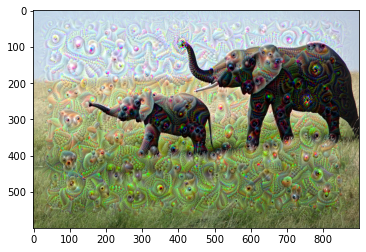

In [4]:
import numpy as np

import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3)) 
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)
        

step = 0.01
num_octave = 3
octave_scale = 1.3
iterations = 20

max_loss = 100.

base_image_path = './datasets/original_photo_deep_dream.jpeg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(-2, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
                  for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./datasets/final_dream.jpg')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pil_img = deprocess_image(np.copy(img))
imgplot = plt.imshow(pil_img)
plt.show()

In [ ]:
model.summary()